# SUMMA Turbulence Scheme Conversion
### fortran to python conversions of SUMMA's turbulence schemes

- test offline, uncoupled turbulence schemes
- idealized simulations of stability (no real data)

### Status
This script is now out of date. See TF.turbpyTest for testing of the turbpy package, which supersedes this notebook.

In [13]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

In [14]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

In [15]:
ave_slp      =  101325.0             # mean sea level pressure              (Pa)
vkc          =       0.4             # von Karman constant                  (-)
satvpfrz     =     610.8             # sat vapour pressure at 273.16K       (Pa)
w_ratio      =       0.622           # molecular ratio water to dry air     (-)
R_da         =     287.053           # gas constant for dry air             (Pa K-1 m3 kg-1; J kg-1 K-1)
R_wv         =     461.285           # gas constant for water vapor         (Pa K-1 m3 kg-1; J kg-1 K-1)
gravity      =       9.80616         # acceleration of gravity              (m s-2)
Cp_air       =    1005.              # specific heat of air                 (J kg-1 K-1)
Cp_ice       =    2114.              # specific heat of ice                 (J kg-1 K-1)
Cp_soil      =     850.              # specific heat of soil                (J kg-1 K-1)
Cp_water     =    4181.              # specific heat of liquid water        (J kg-1 K-1)
Tfreeze      =     273.16            # temperature at freezing              (K)
TriplPt      =     273.16            # triple point of water                (K)
LH_fus       =  333700.0             # latent heat of fusion                (J kg-1)
LH_vap       = 2501000.0             # latent heat of vaporization          (J kg-1)
LH_sub       = 2834700.0             # latent heat of sublimation           (J kg-1)
lambda_air   =       0.026           # thermal conductivity of air          (W m-1 K-1)
lambda_ice   =       2.50            # thermal conductivity of ice          (W m-1 K-1)
lambda_water =       0.60            # thermal conductivity of liquid water (W m-1 K-1)
iden_air     =       1.293           # intrinsic density of air             (kg m-3)
iden_ice     =     917.0             # intrinsic density of ice             (kg m-3)
iden_water   =    1000.0             # intrinsic density of liquid water    (kg m-3)
secprday     =   86400.              # number of seconds in a day
secprhour    =    3600.              # number of seconds in an hour
secprmin     =      60.              # number of seconds in a minute

### Check behavior of stability functions


In [16]:
ixStability = ('standard','louisInversePower','mahrtExponential')
ixDerivMethod = 'none'
groundTemp = 258.
airtemp = np.arange(253,293)
windspd = 1.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
critRichNumber = .2
Louis79_bparam = 9.4
Mahrt87_eScale = 1.
scalarGroundSnowFraction  = 1.
VPair = 12332. # (Pa)
soilRelHumidity = 1.
# "soil"RelHumidity 
# scalarSoilRelHumidity  = scalarGroundSnowFraction*1._dp + (1._dp - scalarGroundSnowFraction)*soilRelHumidity_noSnow
airpres = ave_slp

## Define Functions

### Turbulence

In [29]:
def turbFluxes(
        # input: model control
        ixDerivMethod,                  # choice of method used to compute derivative (analytical or numerical)
        ixStability,                    # method for calculating stability
        # input: above-canopy forcing data
        airTemp,                        # air temperature at some height above the surface (K)
        airPres,                        # air pressure of the air above the vegetation canopy (Pa)
        VPair,                          # vapor pressure of the air above the vegetation canopy (Pa)
        windspd,                        # wind speed above the canopy (m s-1)    
        # input: canopy and ground temperature
        groundTemp,                     # ground temperature (K)
        # input: diagnostic variables
        soilRelHumidity,                # relative humidity in the soil pores [0-1]
        mHeight
        ):
# --------------------------------------------------------------------------------------------------------------------
    if np.isnan(airTemp) or np.isnan(airPres) or np.isnan(VPair) or np.isnan(groundTemp):
        return (
                np.nan,                # ground conductance for sensible heat (m s-1)
                np.nan,                # ground conductance for latent heat (m s-1)
                # output: fluxes from non-vegetated surfaces
                np.nan,                      # sensible heat flux from ground surface (W m-2)
                np.nan,                      # latent heat flux from ground surface (W m-2)
                np.nan,                     # net turbulent heat fluxes at the ground surface (W m-2)
                # output: energy flux derivatives
                np.nan,           # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
                )
    
    
    ########
    # Local variables
    evapSmooth=1.                                  # smoothing parameter for latent heat (W m-2)
    volHeatCapacityAir = iden_air*Cp_air           # volumetric heat capacity of air (J m-3)
    latentHeatConstant = iden_air*w_ratio/airPres  # latent heat constant for (kg m-3 Pa-1)
    # soilResistance is an unclear term for snow -- there is no resistance from snow: Sellers (1992)
    # scalarSoilResistance = scalarGroundSnowFraction*1. + (1. - groundSnowFraction)*EXP(8.25 - 4.225*soilEvapFactor)  
    soilResistance = 1.
    
    ########
    # saturation vapor pressure at the temperature of the ground (Pa)
    (satVP_GroundTemp,empty) = satVapPress(groundTemp - Tfreeze)
    
    #######
    # Latent Heat - Vaporization or sublimation. 
    # NOTE: The physics implied here is wrong. Point to bring up with Martyn/Bart
    if scalarGroundSnowFraction > 0. and groundTemp < Tfreeze:
        latHeatSubVapGround = LH_sub  # sublimation from snow
    # case when the ground is snow-free
    # evaporation of water in the soil pores, this occurs even if frozen because of super-cooled water
    elif scalarGroundSnowFraction == 0.:
        latHeatSubVapGround = LH_vap
    else:
        latHeatSubVapGround = LH_sub
    
    ########
    # compute resistances
    derivDesired = 'analytical' in ixDerivMethod or 'numerical' in ixDerivMethod
    resistOut = aeroResist(
                    derivDesired,               # flag to indicate if analytical derivatives are desired
                    ixStability,                # choice of stability function
                    # input: above-canopy forcing data
                    mHeight,                    # measurement height (m)
                    airTemp,                    # air temperature at some height above the surface (K)
                    windspd,                    # wind speed at some height above the surface (m s-1)
                    # input: temperature (canopy, ground, canopy air space)
                    groundTemp,                 # ground temperature (K)
                    # input: diagnostic variables
                    snowDepth,                  # snow depth (m)
                    # input: parameters
                    z0Ground,                   # surface roughness length (below canopy/non-vegetated [snow]) (m)
                    critRichNumber,             # critical value for the bulk Richardson number (-)
                    Louis79_bparam,             # parameter in Louis (1979) stability function
                    Mahrt87_eScale              # exponential scaling factor in the Mahrt (1987) stability function
                    )
    
    # Unpack resistances
    (RiBulkGround,                  # bulk Richardson number for the ground surface (-)
    groundStabilityCorrection,      # stability correction for the ground surface (-)
    groundResistance,               # below canopy aerodynamic resistance (s m-1)
    dGroundResistance_dTGround      # derivative in ground resistance w.r.t. ground temperature (s m-1 K-1)
    ) = resistOut
    
    ########
    # compute conductances, and derivatives...
    # NOTE: soilResistance accounts for fractional snow, and =0 when snow cover is 100%
    groundConductanceLH = 1./(groundResistance + soilResistance)
    groundConductanceSH = 1./groundResistance
    
    ########
    # compute sensible and latent heat fluxes, and derivatives...
    # (positive downwards)
    senHeatGround      = -volHeatCapacityAir*groundConductanceSH*(groundTemp - airTemp)
    latHeatGround      = -latHeatSubVapGround*latentHeatConstant*groundConductanceLH * \
                          (satVP_GroundTemp*soilRelHumidity - VPair)
    
    
    # compute derivatives
    if ixDerivMethod == 'analytical':
        # compute derivatives for the ground fluxes w.r.t. ground temperature
        # d(ground sensible heat flux)/d(ground temp)
        dSenHeatGround_dTGround =   (-volHeatCapacityAir*dGroundCondSH_dGroundTemp)*(groundTemp - airTemp) + \
                                    (-volHeatCapacityAir*groundConductanceSH)
        # d(ground latent heat flux)/d(ground temp)
        dLatHeatGround_dTGround =   (-latHeatSubVapGround*latentHeatConstant*dGroundCondLH_dGroundTemp) * \
                                    (satVP_GroundTemp*soilRelHumidity - VPair) + \
                                    (-latHeatSubVapGround*latentHeatConstant*groundConductanceLH) * \
                                    dSVPGround_dGroundTemp*soilRelHumidity

    ########
    # net turbulent flux at the ground surface (W m-2)
    turbFluxGround = senHeatGround + latHeatGround

    # compute derivatives
    if ixDerivMethod == 'analytical':
        # (energy derivatives)
        # derivative in net ground turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        dTurbFluxGround_dTGround = dSenHeatGround_dTGround + dLatHeatGround_dTGround
    else: # (just make sure we return something)
        # (energy derivatives)
        dTurbFluxGround_dTGround = -9999

    return (
        groundConductanceSH,                # ground conductance for sensible heat (m s-1)
        groundConductanceLH,                # ground conductance for latent heat (m s-1)
        # output: fluxes from non-vegetated surfaces
        senHeatGround,                      # sensible heat flux from ground surface (W m-2)
        latHeatGround,                      # latent heat flux from ground surface (W m-2)
        turbFluxGround,                     # net turbulent heat fluxes at the ground surface (W m-2)
        # output: energy flux derivatives
        dTurbFluxGround_dTGround,           # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        )

### Aerodynamic Resistance

In [30]:
def aeroResist( derivDesired,               # flag to indicate if analytical derivatives are desired
                ixStability,                # choice of stability function
                # input: above-canopy forcing data
                mHeight,                    # measurement height (m)
                airTemp,                    # air temperature at some height above the surface (K)
                windspd,                    # wind speed at some height above the surface (m s-1)
                # input: temperature (canopy, ground, canopy air space)
                groundTemp,                 # ground temperature (K)
                # input: diagnostic variables
                snowDepth,                  # snow depth (m)
                # input: parameters
                z0Ground,                   # surface roughness length (below canopy/non-vegetated [snow]) (m)
                critRichNumber,             # critical value for the bulk Richardson number (-)
                Louis79_bparam,             # parameter in Louis (1979) stability function
                Mahrt87_eScale              # exponential scaling factor in the Mahrt (1987) stability function
                ):
# -------------------------------------------------------------------------------------------------------
# compute aerodynamic resistances
# Refs: Choudhury and Monteith (4-layer model for heat budget of homogenous surfaces; QJRMS, 1988)
#       Niu and Yang (Canopy effects on snow processes; JGR, 2004)
#       Mahat et al. (Below-canopy turbulence in a snowmelt model, WRR, 2012)
# -------------------------------------------------------------------------------------------------------

    # local variables: general
    C_r = 0.3                 # roughness element drag coefficient (-) from Raupach (BLM, 1994)
    C_s = 0.00                # substrate surface drag coefficient (-) from Raupach (BLM, 1994)
    approxDragCoef_max = 0.   # maximum value of the approximate drag coefficient (-) from Raupach (BLM, 1994)
    vkc = 0.4                 # von Karman constant (-)

    ########
    # compute resistance for the case without a canopy (bare ground, or canopy completely buried with snow)

    # check that measurement height above the ground surface is above the roughness length
    if mHeight < snowDepth+z0Ground:
        error('measurement height < snow depth + roughness length')

    # turbulent transfer coefficient under conditions of neutral stability (-)
    groundExNeut = (vkc**2.) / ( np.log((mHeight - snowDepth)/z0Ground)**2.) 
    # compute the resistance between the surface and canopy air UNDER NEUTRAL CONDITIONS (s m-1)
    groundResistanceNeutral = 1. / (groundExNeut*windspd)

    # define height above the snow surface
    heightAboveGround  = mHeight - snowDepth

    # check that measurement height above the ground surface is above the roughness length
    if heightAboveGround < z0Ground:
        print(\
                'z0Ground = %d \n' \
                'mHeight  = %d \n' \
                'snowDepth = %d \n' \
                'heightAboveGround = %d \n' \
                , (z0Ground,mHeight,snowDepth,heightAboveGround))
        error('height above ground < roughness length [likely due to snow accumulation]')

    # compute ground stability correction
    aStabilityOut = aStability(
                  # input
                  derivDesired,                                 # logical flag to compute analytical derivatives
                  ixStability,                                  # choice of stability function
                  # input: forcing data, diagnostic and state variables
                  heightAboveGround,                            # measurement height above the ground surface (m)
                  airTemp,                                      # temperature above the ground surface (K)
                  groundTemp,                                   # trial value of surface temperature (K)
                  windspd,                                      # wind speed above the ground surface (m s-1)
                  # input: stability parameters
                  critRichNumber,                               # critical value for the bulk Richardson number (-)
                  Louis79_bparam,                               # parameter in Louis (1979) stability function
                  Mahrt87_eScale,                               # exponential scaling factor in Mahrt stability
                  )

    # Unpack
    (RiBulkGround,                               # bulk Richardson number (-)
    groundStabilityCorrection,                   # stability correction for turbulent heat fluxes (-)
    dGroundStabilityCorrection_dRich,            # derivative in stab. corr. w.r.t. Ri for the ground surface (-)
    dGroundStabilityCorrection_dAirTemp,         # derivative in stab. corr. w.r.t. air temperature (K-1)
    dGroundStabilityCorrection_dSfcTemp)  = aStabilityOut # derivative in stab. corr. w.r.t. surface temperature (K-1)

    # compute the ground resistance (after stability corrections)
    groundResistance = groundResistanceNeutral/groundStabilityCorrection
    if groundResistance < 0.:
        error('ground resistance < 0 [no vegetation]')

    # if analytical derivatives are desired
    if derivDesired: 

        # compute derivatives for ground resistance
        dGroundResistance_dTGround = -dGroundStabilityCorrection_dSfcTemp/ \
                                        (windspd*groundExNeut*groundStabilityCorrection**2.)
    else:
        dGroundResistance_dTGround = -9999

    return  (RiBulkGround,              # bulk Richardson number for the ground surface (-)
        groundStabilityCorrection,      # stability correction for the ground surface (-)
        groundResistance,               # below canopy aerodynamic resistance (s m-1)
        dGroundResistance_dTGround)     # derivative in ground resistance w.r.t. ground temperature (s m-1 K-1)

### Stability Functions

In [38]:
#### "standard" stability correction, a la Anderson 1976
def standardStability(RiBulk,critRichNumber):    
    # compute surface-atmosphere exchange coefficient (-)
    if RiBulk <  critRichNumber:
        stabilityCorrection = (1. - 5.*RiBulk)**2.
    if RiBulk >= critRichNumber:
        # stabilityCorrection = epsilon(stabilityCorrection)
        stabilityCorrection = machineEpsilon

    # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
    if computeDerivative:
        if RiBulk <  critRichNumber:
            dStabilityCorrection_dRich = (-5.) * 2.*(1. - 5.*RiBulk)
        if RiBulk >= critRichNumber:
            dStabilityCorrection_dRich = 0.
    else:
        dStabilityCorrection_dRich = -9999.
    return stabilityCorrection,dStabilityCorrection_dRich

#### Louis 1979
def louisInversePower(RiBulk,critRichNumber,Louis79_bparam):
    # scale the "b" parameter for stable conditions
    bprime = Louis79_bparam/2.
    # compute surface-atmosphere exchange coefficient (-)
    stabilityCorrection = 1. / ( (1. + bprime*RiBulk)**2. )
    if stabilityCorrection < machineEpsilon:
        stabilityCorrection = machineEpsilon
    # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
    if computeDerivative:
        dStabilityCorrection_dRich = bprime * (-2.)*(1. + bprime*RiBulk)**(-3.)
    else:
        dStabilityCorrection_dRich = -9999.
    return stabilityCorrection,dStabilityCorrection_dRich

#### Mahrt 1987
def mahrtExponential(RiBulk,critRichNumber,Mahrt87_eScale):
    # compute surface-atmosphere exchange coefficient (-)
    stabilityCorrection = np.exp(-Mahrt87_eScale * RiBulk)
    if stabilityCorrection < machineEpsilon:
        stabilityCorrection = machineEpsilon
    # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
    if computeDerivative:
        dStabilityCorrection_dRich = (-Mahrt87_eScale) * np.exp(-Mahrt87_eScale * RiBulk)
    else:
        dStabilityCorrection_dRich = -9999.
    return stabilityCorrection,dStabilityCorrection_dRich

In [39]:
#### Actual stability scheme
def aStability(# input: control
               computeDerivative,              # logical flag to compute analytical derivatives
               ixStability,                    # choice of stability function
               # input: forcing data, diagnostic and state variables
               mHeight,                        # measurement height (m)
               airTemp,                        # air temperature (K)
               sfcTemp,                        # surface temperature (K)
               windspd,                        # wind speed (m s-1)
               # input: stability parameters
               critRichNumber,                 # critical value for the bulk Richardson number (-)
               Louis79_bparam,                 # parameter in Louis (1979) stability function
               Mahrt87_eScale,                 # exponential scaling factor in the Mahrt (1987) stability function
               ):
# --------------------------------------------------------------------------------------------------------------------
    #### "standard" stability correction, a la Anderson 1976
    def standardStability():    
        # compute surface-atmosphere exchange coefficient (-)
        if RiBulk <  critRichNumber:
            stabilityCorrection = (1. - 5.*RiBulk)**2.
        elif RiBulk >= critRichNumber:
            # stabilityCorrection = epsilon(stabilityCorrection)
            stabilityCorrection = machineEpsilon
        else: 
            stabilityCorrection = machineEpsilon
            
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            if RiBulk <  critRichNumber:
                dStabilityCorrection_dRich = (-5.) * 2.*(1. - 5.*RiBulk)
            if RiBulk >= critRichNumber:
                dStabilityCorrection_dRich = 0.
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich

    #### Louis 1979
    def louisInversePower():
        # scale the "b" parameter for stable conditions
        bprime = Louis79_bparam/2.
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = 1. / ( (1. + bprime*RiBulk)**2. )
        if stabilityCorrection < machineEpsilon:
            stabilityCorrection = machineEpsilon
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich = bprime * (-2.)*(1. + bprime*RiBulk)**(-3.)
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich

    #### Mahrt 1987
    def mahrtExponential():
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = np.exp(-Mahrt87_eScale * RiBulk)
        if stabilityCorrection < machineEpsilon:
            stabilityCorrection = machineEpsilon
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich = (-Mahrt87_eScale) * np.exp(-Mahrt87_eScale * RiBulk)
        else:
            dStabilityCorrection_dRich = -9999
        return stabilityCorrection,dStabilityCorrection_dRich   

    #### Stability Error Message
    def stabErrMess():
        error('Did not recognize stability choice: '+ixStability+'\n',
             'Valid stability options: standard, louisInversePower, mahrtExponential')
# --------------------------------------------------------------------------------------------------------------------
    
    # compute the bulk Richardson number (-)
    bulkRichardsonOut = bulkRichardson(# input
                                        airTemp,                        # air temperature (K)
                                        sfcTemp,                        # surface temperature (K)
                                        windspd,                        # wind speed (m s-1)
                                        mHeight,                        # measurement height (m)
                                        computeDerivative,              # flag to compute the derivative
                                        )

    # output
    (RiBulk,                             # bulk Richardson number (-)
    dRiBulk_dAirTemp,                    # derivative in the bulk Richardson number w.r.t. air temperature (K-1)
    dRiBulk_dSfcTemp) = bulkRichardsonOut # derivative in the bulk Richardson number w.r.t. surface temperature (K-1)
    
    # set derivative to one if not computing it
    if not computeDerivative:
        dStabilityCorrection_dRich    = 1.
        dStabilityCorrection_dAirTemp = 1.
        dStabilityCorrection_dSfcTemp = 1.

    #########
    # process unstable cases
    if RiBulk<0.:
        # compute surface-atmosphere exchange coefficient (-)
        stabilityCorrection = (1. - 16.*RiBulk)**0.5
        # compute derivative in surface-atmosphere exchange coefficient w.r.t. temperature (K-1)
        if computeDerivative:
            dStabilityCorrection_dRich    = (-16.) * 0.5 *(1. - 16.*RiBulk)**(-0.5)
            dStabilityCorrection_dAirTemp = dRiBulk_dAirTemp * dStabilityCorrection_dRich
            dStabilityCorrection_dSfcTemp = dRiBulk_dSfcTemp * dStabilityCorrection_dRich
        
    ######## 
    # process stable cases
    # Use a dictionary of functions to select stability function
    else:
        stabilityCase = {
            'standard': standardStability,
            'louisInversePower': louisInversePower,
            'mahrtExponential': mahrtExponential,
        }

        # Get the function from switcher dictionary
        func = stabilityCase.get(ixStability, stabErrMess)

        # Execute the function
        stabilityCorrection,dStabilityCorrection_dRich = func()

        # Derivative of stable cases
        if computeDerivative:
            dStabilityCorrection_dAirTemp = dRiBulk_dAirTemp * dStabilityCorrection_dRich
            dStabilityCorrection_dSfcTemp = dRiBulk_dSfcTemp * dStabilityCorrection_dRich
    
    
    return  (RiBulk,                                # bulk Richardson number (-)
            stabilityCorrection,              # stability correction for turbulent heat fluxes (-)
            dStabilityCorrection_dRich,             # derivative in stab. corr. w.r.t. Ri for the ground surface (-)
            dStabilityCorrection_dAirTemp,          # derivative in stab. corr. w.r.t. air temperature (K-1)
            dStabilityCorrection_dSfcTemp)          # derivative in stab. corr. w.r.t. sfc temperature (K-1)

### Bulk Richardson

In [40]:
def bulkRichardson(# input
                   airTemp,            # air temperature (K)
                   sfcTemp,            # surface temperature (K)
                   windspd,            # wind speed (m s-1)
                   mHeight,            # measurement height (m)
                   computeDerivative,  # flag to compute the derivative
                     ):

# --------------------------------------------------------------------------------------------------------------------
    ########
    # Local variables
    T_grad = airTemp - sfcTemp
    T_mean = 0.5*(airTemp + sfcTemp)
    RiMult = (gravity*mHeight)/(windspd*windspd)
    # compute the Richardson number
    RiBulk = (T_grad/T_mean) * RiMult
    
    ########
    # compute the derivative in the Richardson number
    if computeDerivative:
        dRiBulk_dAirTemp =  RiMult/T_mean - RiMult*T_grad/(0.5*((airTemp + sfcTemp)**2.))
        dRiBulk_dSfcTemp = -RiMult/T_mean - RiMult*T_grad/(0.5*((airTemp + sfcTemp)**2.))
    else:
        dRiBulk_dAirTemp = 1.
        dRiBulk_dSfcTemp = 1.

    return (RiBulk,                     # bulk Richardson number (-)
            dRiBulk_dAirTemp,           # derivative in the bulk Richardson number w.r.t. air temperature (K-1)
            dRiBulk_dSfcTemp)           # derivative in the bulk Richardson number w.r.t. surface temperature (K-1)

### Conversion functions

In [41]:
def vapPress(q,p):
# Input
# q :        specific humidity (g g-1)
# p :        pressure (Pa)
# Output
# vapPress : vapor pressure (Pa)

    w_ratio = 0.622                     # molecular weight ratio of water to dry air (-)
    w = q / (1. - q)                    # mixing ratio (-)
    vapPress = (w/(w + w_ratio))*p      # vapor pressure (Pa)

    return vapPress

def satVapPress(TC):
# Uses Teten's formula to compute saturated vapor pressure (Pa)
# NOTE: temperature units are degC !!!!
# input
# TC : temperature (C)
# output
# SVP      : saturation vapor pressure (Pa)
# dSVP_dT  : d(SVP)/dT

    X1 = 17.27
    X2 = 237.30
    dx = 1.*10**(-8)                                        # finite difference increment
    SATVPFRZ = 610.8                                        # Saturation water vapour pressure at 273.16K (Pa)
    SVP     = SATVPFRZ * np.exp( (X1*TC)/(X2 + TC) )        # Saturated Vapour Press (Pa)
    dSVP_dT = SVP * (X1/(X2 + TC) - X1*TC/(X2 + TC)**2.)
    
    return SVP,dSVP_dT

## Test Stability Functions

In [42]:
## Parameters
m = 1.
RiBulk = np.arange(0.01,1,.01)
critRichNumber = 0.2

machineEpsilon = (np.finfo(float).eps)
computeDerivative = 0

## Calculate stability
mahrtStab = np.zeros_like(RiBulk)
louisStab = np.zeros_like(RiBulk)
standStab = np.zeros_like(RiBulk)

for n,r in enumerate(RiBulk):
    (mahrtStab[n],empty) = mahrtExponential(r,critRichNumber,m)
    (louisStab[n],empty) = louisInversePower(r,critRichNumber,Louis79_bparam)
    (standStab[n],empty) = standardStability(r,critRichNumber)


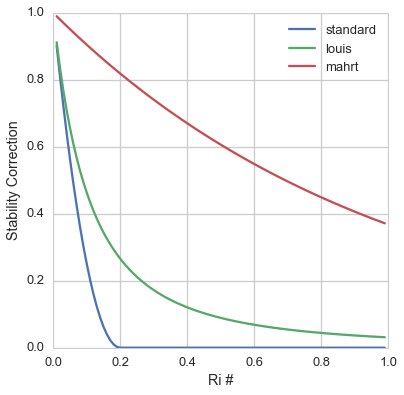

In [43]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(RiBulk,standStab,label='standard')
ax.plot(RiBulk,louisStab,label='louis')
ax.plot(RiBulk,mahrtStab,label='mahrt')
ax.legend(loc='best')
ax.set_ylabel('Stability Correction')
ax.set_xlabel('Ri #')

os.chdir(dirPrint)
fig.savefig('ATMS547.StabilityCorrections.pdf')

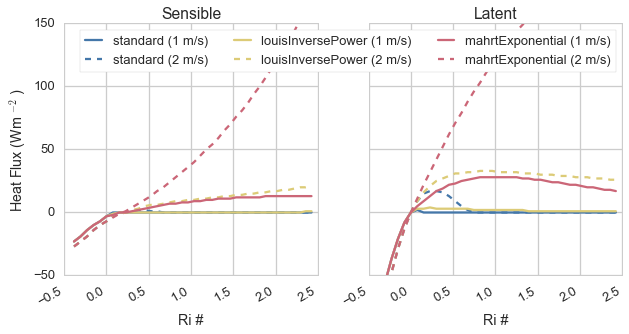

In [45]:
#######
# Plotting arguments
fig,axes = plt.subplots(1,2,sharey=True,figsize=(10,5))

# Plotting parameters
Qmax = 150
Qmin = -50
RiMax = 4
RiMin = -.1

########
# Bulk Richardson number
Ri = bulkRichardson(airtemp,
                    groundTemp,
                    windspd,
                    mHeight,
                    False)

colr = kgraph.SRON(3)

for sindex,stab in enumerate(ixStability):
    senHeatGround = np.zeros_like(airtemp)                  # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.zeros_like(airtemp)                  # latent heat flux from ground surface (W m-2)

    (VPair,empty) = satVapPress(airtemp-273)
    VPair = VPair*.8

    for n,(tair,vp) in enumerate(zip(airtemp,VPair)):
        tfOut = turbFluxes(ixDerivMethod,stab,tair,airpres,vp,windspd,groundTemp,soilRelHumidity,mHeight)

        (_,        # ground conductance for sensible heat (m s-1)
        _,         # ground conductance for latent heat (m s-1)
        senHeatGround[n],               # sensible heat flux from ground surface (W m-2)
        latHeatGround[n],               # latent heat flux from ground surface (W m-2)
        _,              # net turbulent heat fluxes at the ground surface (W m-2)
        _,    # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        ) = tfOut
        
    ax = axes[0]
    ax.plot(Ri[0], latHeatGround,color=colr[sindex])
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_ylabel('Heat Flux (Wm $^{-2}$ )')
    ax.set_title('Sensible')

    ax = axes[1]
    ax.plot(Ri[0], senHeatGround,color=colr[sindex],label=stab+' (1 m/s)')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title('Latent')
    ax.set_title('Net')
    
    
    for n,(tair,vp) in enumerate(zip(airtemp,VPair)):
        tfOut = turbFluxes(ixDerivMethod,stab,tair,airpres,vp,2.,groundTemp,soilRelHumidity,mHeight)

        (_,        # ground conductance for sensible heat (m s-1)
        _,         # ground conductance for latent heat (m s-1)
        senHeatGround[n],               # sensible heat flux from ground surface (W m-2)
        latHeatGround[n],               # latent heat flux from ground surface (W m-2)
        _,              # net turbulent heat fluxes at the ground surface (W m-2)
        _,    # derivative in net turbulent fluxes w.r.t. ground temperature (W m-2 K-1)
        ) = tfOut
        
    ax = axes[0]
    ax.plot(Ri[0], latHeatGround,'--',color=colr[sindex])
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_ylabel('Heat Flux (Wm $^{-2}$ )')
    ax.set_title('Sensible')

    ax = axes[1]
    ax.plot(Ri[0], senHeatGround,'--',color=colr[sindex],label=stab+' (2 m/s)')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title('Latent')
    ax.legend(loc='upper right',frameon=True,ncol = 3,handlelength=1.3)

fig.autofmt_xdate()
fig.savefig('AMTS547.OfflineTurb.Idealized.pdf')